# Hyperparameters HMM

Launch `hyperparameters.sh`!

* Fraction scores used for HMM signal, noise and ratio estimation, guards decent SNR in model<br>
`SPAN_DEFAULT_HMM_ESTIMATE_SNR = 0.1`

* Minimal low state mean threshold, guards against too broad peaks<br>
`SPAN_DEFAULT_HMM_LOW_THRESHOLD = 0.3`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import tempfile

def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

def d(a, b):
    return a / b if b != 0 else 0.0

In [3]:
SNRS = [0, 0.001, 0.01, 0.05, 0.1, 0.3]
LOWS = [0, 0.01, 0.1, 0.2, 0.3, 0.5]

PATH = os.path.expanduser('~/data/2025_hyperparameters')
rows = []
for (path, f) in tqdm([(PATH, f) for f in os.listdir(PATH)]):
    if not f.endswith('.peak'):
        continue
    if f.startswith('HSMM_H3K36me3_rep1_'):
        mod, cell, rep = 'H3K36me3', 'HSMM', 'rep1'
    elif f.startswith('HSMM_H3K36me3_rep2_'):
        mod, cell, rep = 'H3K36me3', 'HSMM', 'rep2'
    elif f.startswith('GM12878_H3K4me3_rep1_'):
        mod, cell, rep = 'H3K4me3', 'GM12878', 'rep1'
    elif f.startswith('GM12878_H3K4me3_rep2_'):
        mod, cell, rep = 'H3K4me3', 'GM12878', 'rep2'
    elif f.startswith('GM12878_H3K36me3_rep1_'):
        mod, cell, rep = 'H3K36me3', 'GM12878',' rep1'
    elif f.startswith('GM12878_H3K36me3_rep2_'):
        mod, cell, rep = 'H3K36me3', 'GM12878', 'rep2'
    elif f.startswith('HepG2_H3K27ac_rep1_'):
        mod, cell, rep = 'H3K27ac', 'HepG2', 'rep1'
    elif f.startswith('HepG2_H3K27ac_rep2_'):
        mod, cell, rep = 'H3K27ac', 'HepG2', 'rep2'
    elif f.startswith('CD34_H3K27ac_hg38_ENCFF026YFQ_'):
        mod, cell, rep = 'H3K27ac', 'CD34', ''
    elif f.startswith('OD1_k27ac_hg19_'):
        mod, cell, rep = 'H3K27ac', 'YO', 'OD9'
    elif f.startswith('YD11_k27ac_hg19_'):
        mod, cell, rep = 'H3K27ac', 'YO', 'YD11'
    else:
        continue
    snr, low = None, None
    for s in SNRS:
        for l in LOWS:
            if f'_{s}_{l}.peak' in f:
                snr, low = s, l
                break
    if snr is None or low is None:
        continue
    peaks_path = os.path.join(path, f)
    peaks = lines(peaks_path)
    lens = list(sorted(bedl(peaks_path)))
    lens = lens[int(len(lens) * 0.1): int(len(lens) * 0.9)]
    avl = np.sum(lens) / len(lens)
    rows.append((peaks_path, mod, cell, rep, snr, low, peaks, avl))

t = pd.DataFrame(rows, columns=['file', 'modification', 'cell', 'replicate', 'snr', 'low', 'peaks', 'length'])
t['name'] = t['cell'] + '_' + t['replicate']
t['constraint'] = 'snr_' + t['snr'].astype(str) + '_low_' + t['low'].astype(str)

# Visual aesthetics
t['peaks'] += np.random.normal(0, 10.0, len(t))
t['length'] += np.random.normal(0, 20.0, len(t))
t.loc[t['length'] < 0, 'length'] = 0
t.sort_values(by=['modification', 'name', 'snr', 'low'], inplace=True)
t.sample(3)

  0%|          | 0/1037 [00:00<?, ?it/s]

,file,modification,cell,replicate,snr,low,peaks,length,name,constraint
252,/home/jetbrains/data/2025_hyperparameters/GM12...,H3K4me3,GM12878,rep2,0.10,0.2,5863.611943,1030.805246,GM12878_rep2,snr_0.1_low_0.2
284,/home/jetbrains/data/2025_hyperparameters/YD11...,H3K27ac,YO,YD11,0.01,0.5,2257.472795,1109.016704,YO_YD11,snr_0.01_low_0.5
116,/home/jetbrains/data/2025_hyperparameters/CD34...,H3K27ac,CD34,,0.05,0.3,3894.018733,922.548058,CD34_,snr_0.05_low_0.3


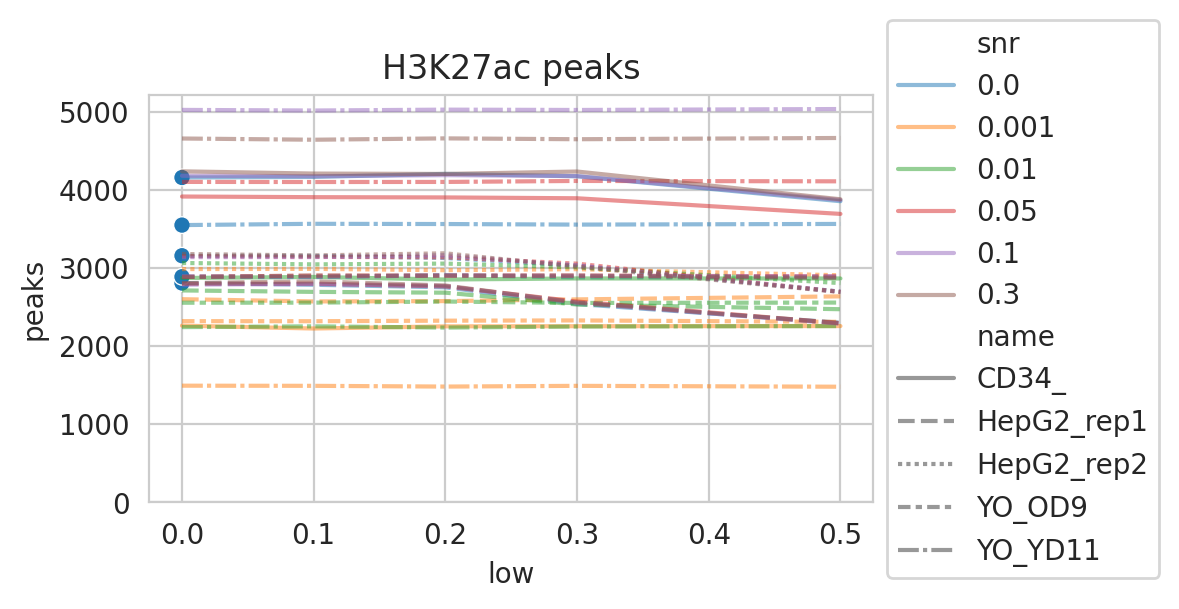

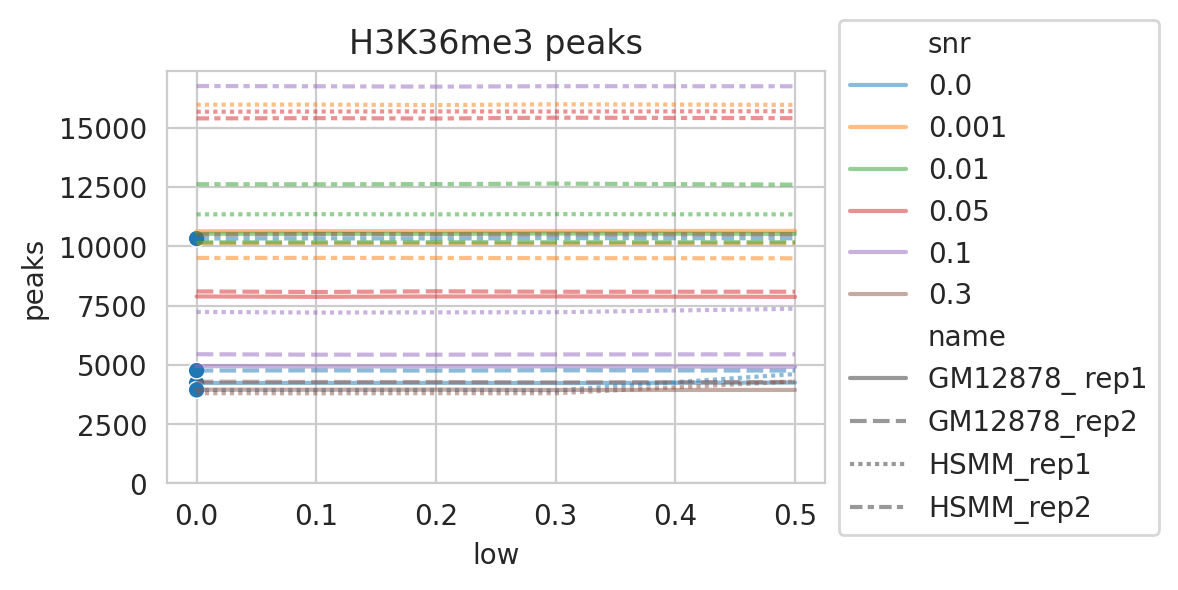

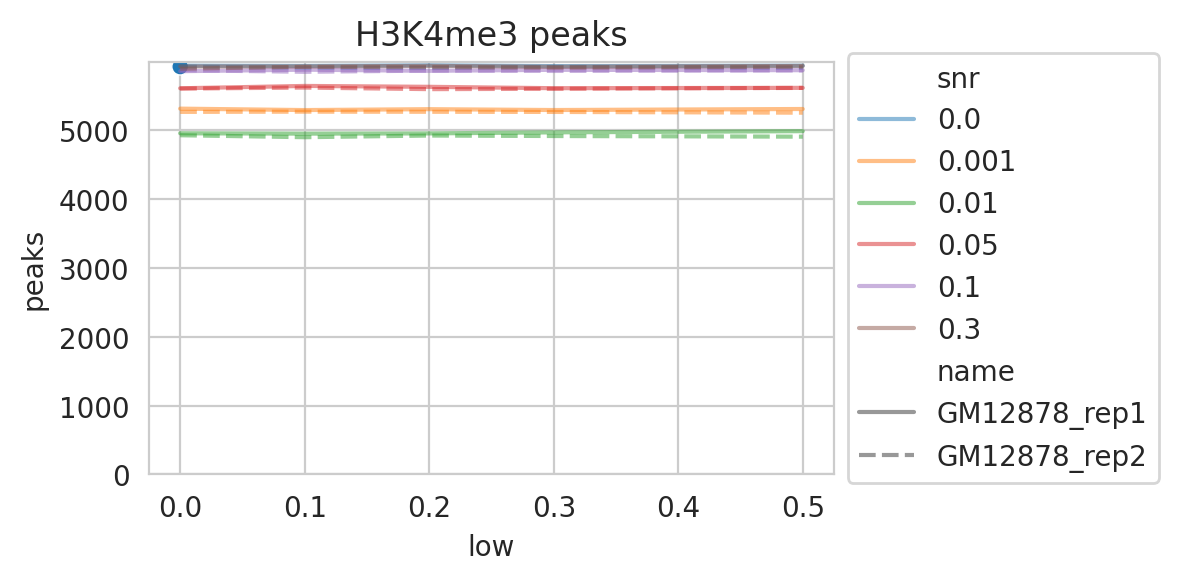

In [4]:
for m, tm in t.groupby('modification'):
    plt.figure(figsize=(6, 3))
    ax = plt.axes()
    sns.lineplot(data=tm, x="low", y='peaks', hue='snr', style='name', palette='tab10', alpha=0.5, ax=ax)
    sns.scatterplot(data=tm[(tm['low'] == 0) & (tm['snr'] == 0)], x="low", y='peaks', hue='snr',
                 palette='tab10', ax=ax, legend=False)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'{m} peaks')
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()



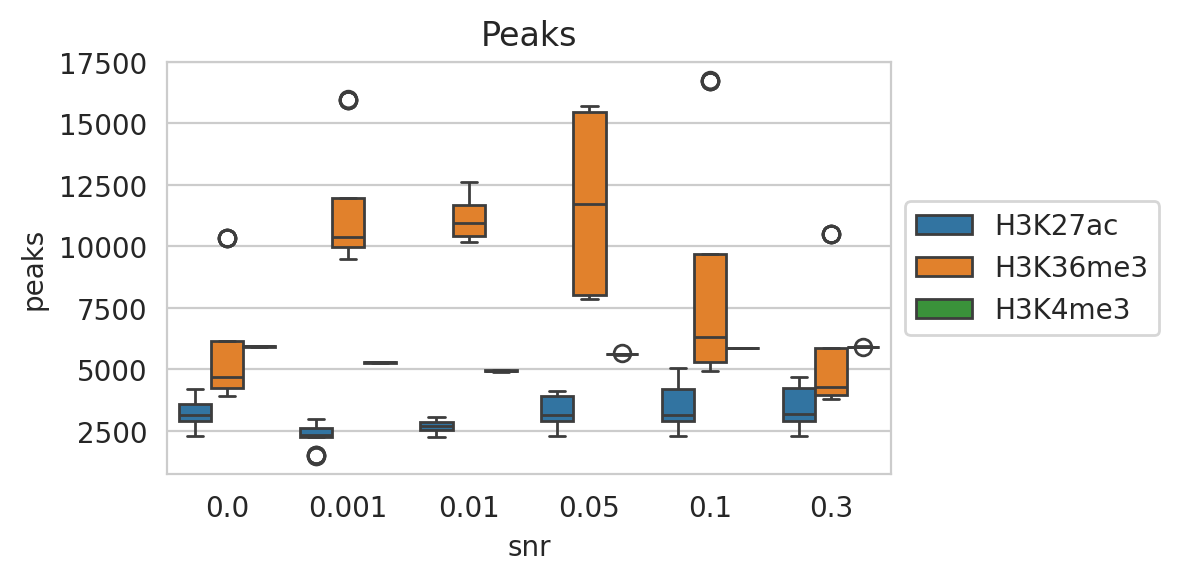

In [5]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x="snr", y='peaks', hue='modification', ax=ax)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title(f'Peaks')
plt.tight_layout()
plt.show()


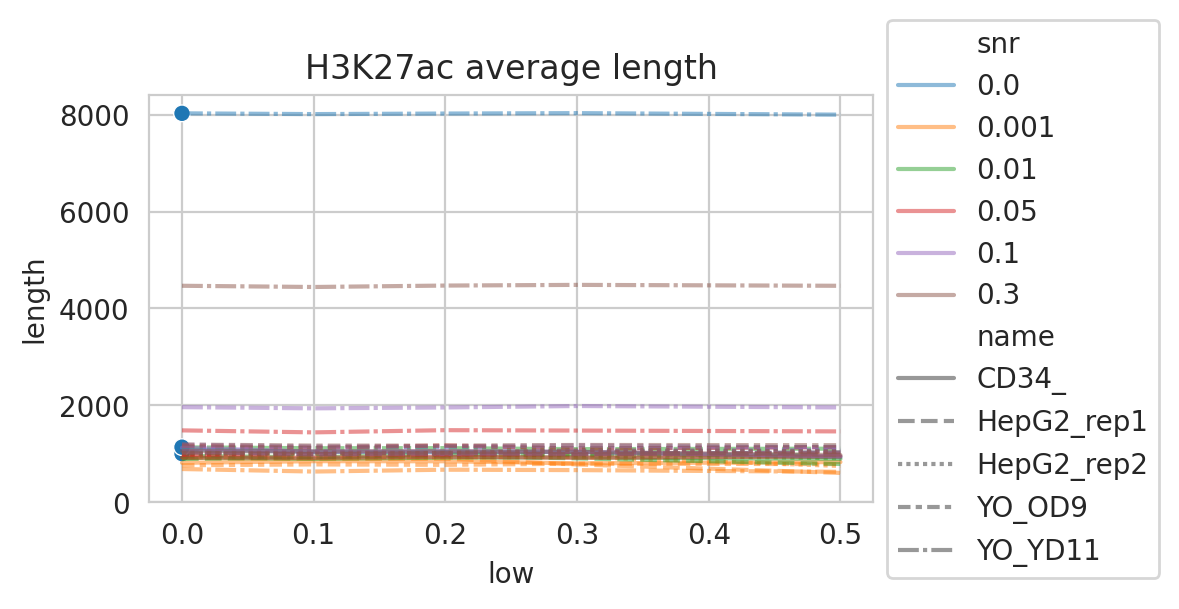

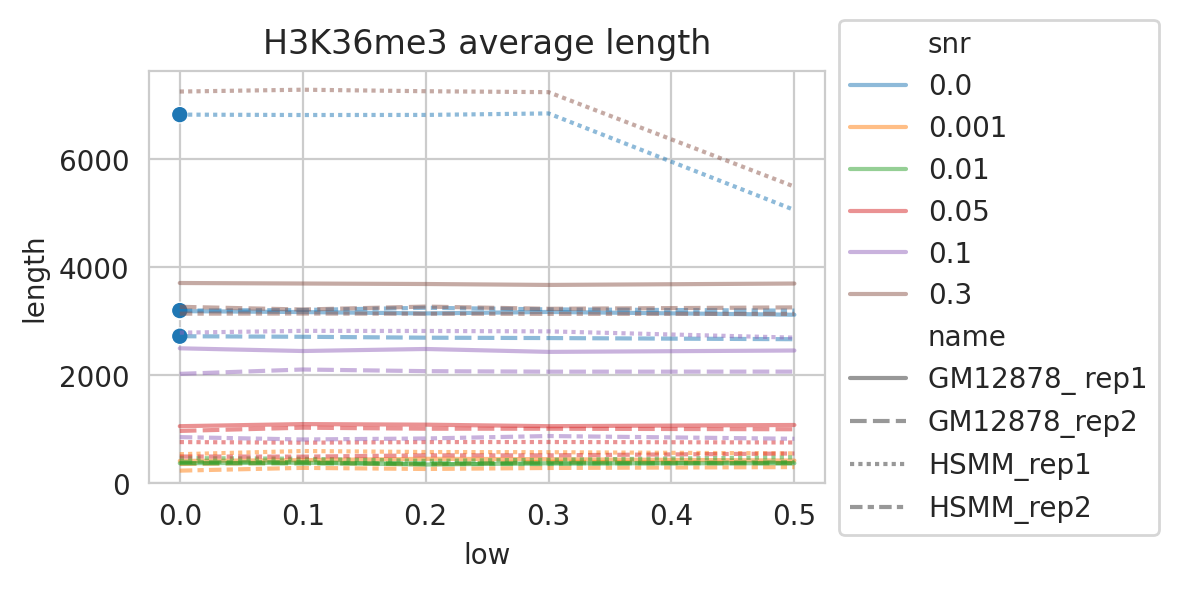

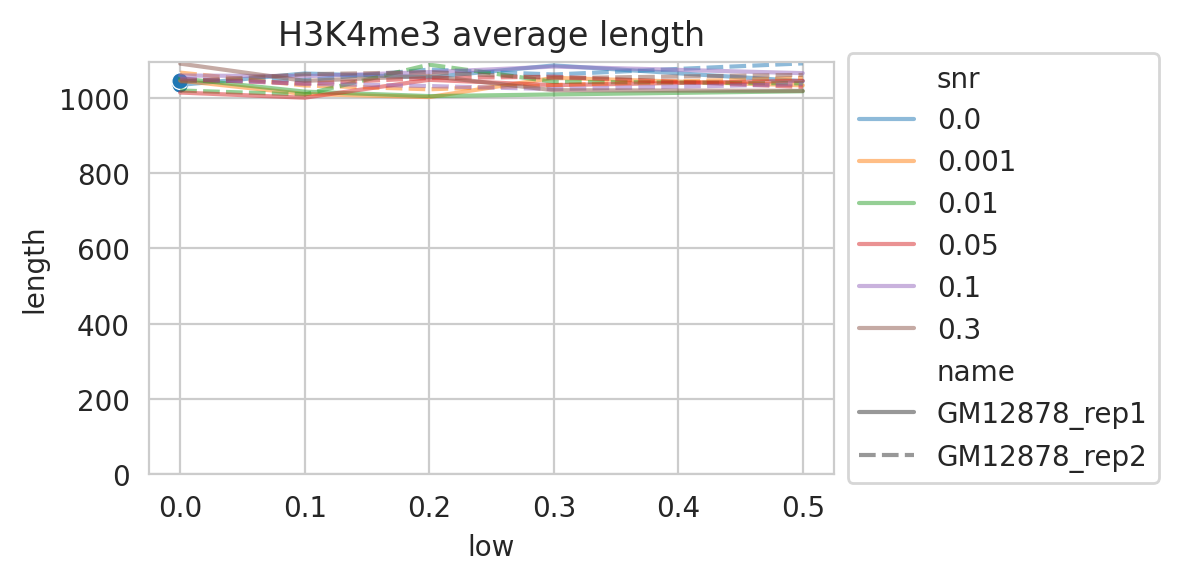

In [6]:
for m, tm in t.groupby('modification'):
    plt.figure(figsize=(6, 3))
    ax = plt.axes()
    sns.lineplot(data=tm, x="low", y='length', hue='snr', style='name', palette='tab10', alpha=0.5, ax=ax)
    sns.scatterplot(data=tm[(tm['low'] == 0) & (tm['snr'] == 0)], x="low", y='length', hue='snr',
                    palette='tab10', ax=ax, legend=False)

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'{m} average length')
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()



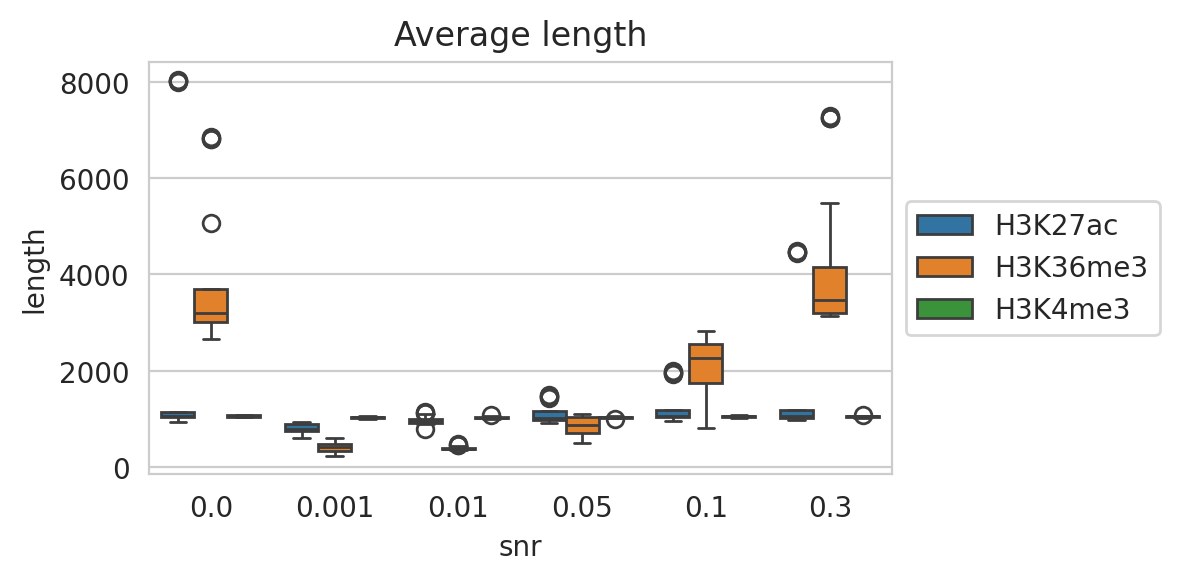

In [7]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x="snr", y='length', hue='modification', ax=ax)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title(f'Average length')
plt.tight_layout()
plt.show()


In [8]:
import pyranges as pr

reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'snr', 'low',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

for (m, c, snr, low), tm in tqdm(t.groupby(['modification', 'cell', 'snr', 'low'])):
    if len(tm) != 2:
        continue
    file1, file2 = pr.read_bed(sorted_file(tm['file'].values[0])), pr.read_bed(sorted_file(tm['file'].values[1]))
    peaks1, peaks2 = len(file1), len(file2)
    peaks1_len, peaks2_len = file1.lengths().sum(), file2.lengths().sum()
    if peaks1 <= 0 or peaks2 <= 0:
            reps_overlap.loc[len(reps_overlap)] = (m, c, snr, low, peaks1, peaks1_len, peaks2, peaks2_len, 0, 0, 0)
    else:
        overlap1 = len(file1.overlap(file2))
        overlap2 = len(file2.overlap(file1))
        overlap_len = file1.intersect(file2).lengths().sum()
        reps_overlap.loc[len(reps_overlap)] = (m, c, snr, low, peaks1, peaks1_len, peaks2, peaks2_len, overlap1, overlap2, overlap_len)
reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
]
reps_overlap

  0%|          | 0/180 [00:00<?, ?it/s]

,modification,cell,snr,low,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks2_overlap,peaks_overlap_len,jaccard
0,H3K27ac,HepG2,0.0,0.0,2799,3956125,3155,4443800,2327,2329,3224160,0.622934
1,H3K27ac,HepG2,0.0,0.1,2799,3956125,3155,4443800,2327,2329,3224160,0.622934
2,H3K27ac,HepG2,0.0,0.2,2770,3846115,3155,4443800,2306,2297,3187305,0.624642
3,H3K27ac,HepG2,0.0,0.3,2561,3418520,3041,4288685,2232,2197,2962625,0.624423
4,H3K27ac,HepG2,0.0,0.5,2289,3043685,2694,3735850,2072,2035,2644005,0.639339
...,...,...,...,...,...,...,...,...,...,...,...,...
145,H3K4me3,GM12878,0.3,0.0,5930,9614655,5915,9611785,5586,5601,9243080,0.925849
146,H3K4me3,GM12878,0.3,0.1,5930,9614655,5915,9611785,5586,5601,9243080,0.925849
147,H3K4me3,GM12878,0.3,0.2,5930,9614655,5915,9611785,5586,5601,9243080,0.925849
148,H3K4me3,GM12878,0.3,0.3,5930,9614655,5915,9611785,5586,5601,9243080,0.925849


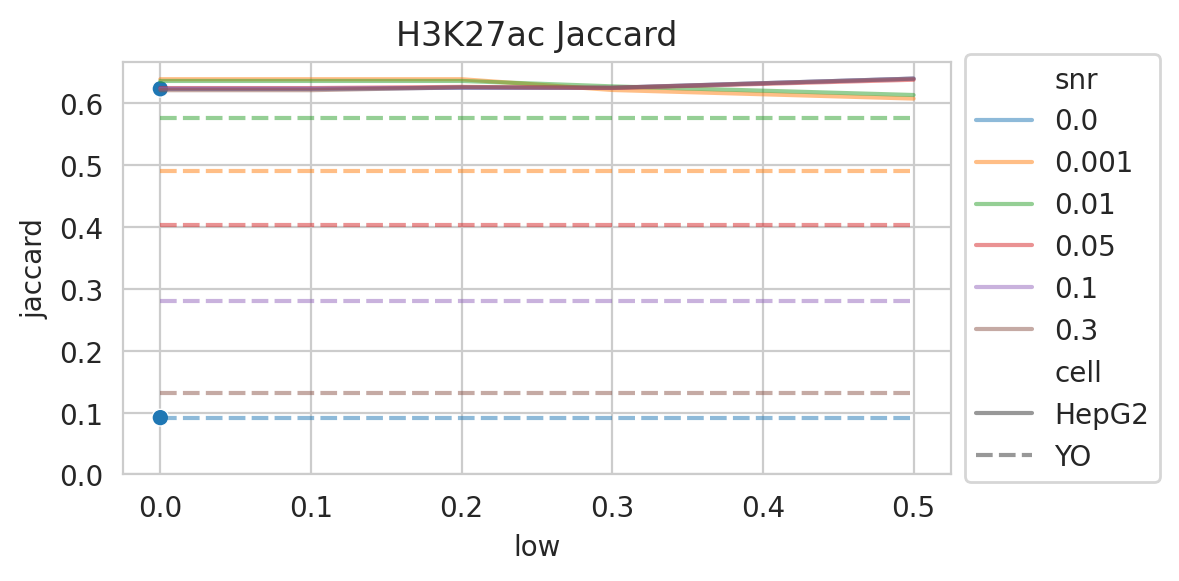

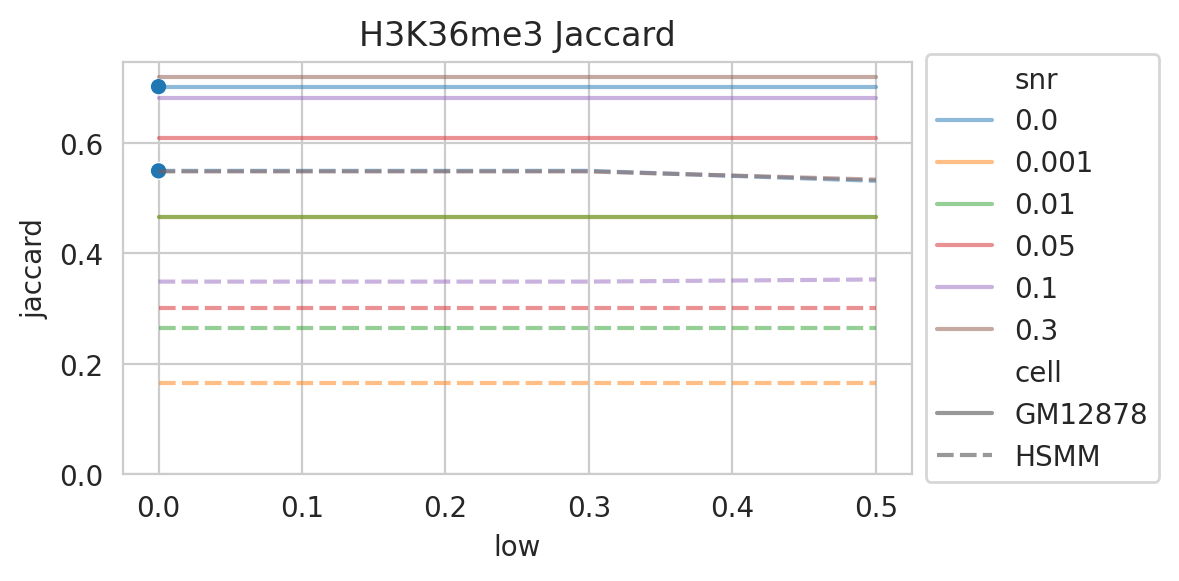

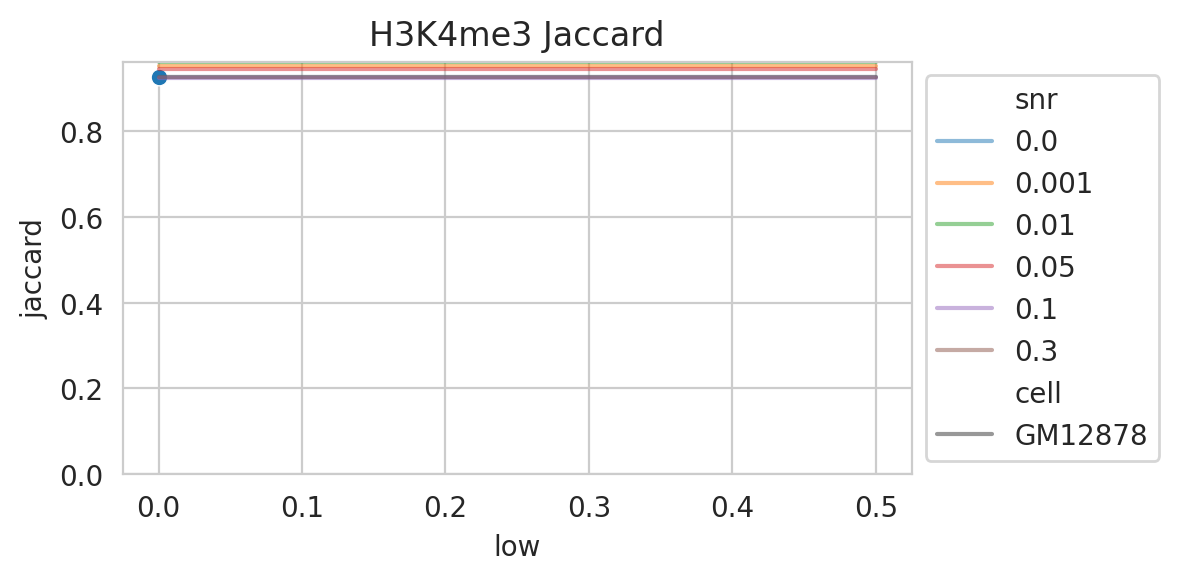

In [9]:
for m, tm in reps_overlap.groupby('modification'):
    plt.figure(figsize=(6, 3))
    ax = plt.axes()
    sns.lineplot(data=tm, x="low", y='jaccard', hue='snr', style='cell', palette='tab10', alpha=0.5, ax=ax)
    sns.scatterplot(data=tm[(tm['low'] == 0) & (tm['snr'] == 0)], x="low", y='jaccard', hue='snr',
                    palette='tab10', ax=ax, legend=False)

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'{m} Jaccard')
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()


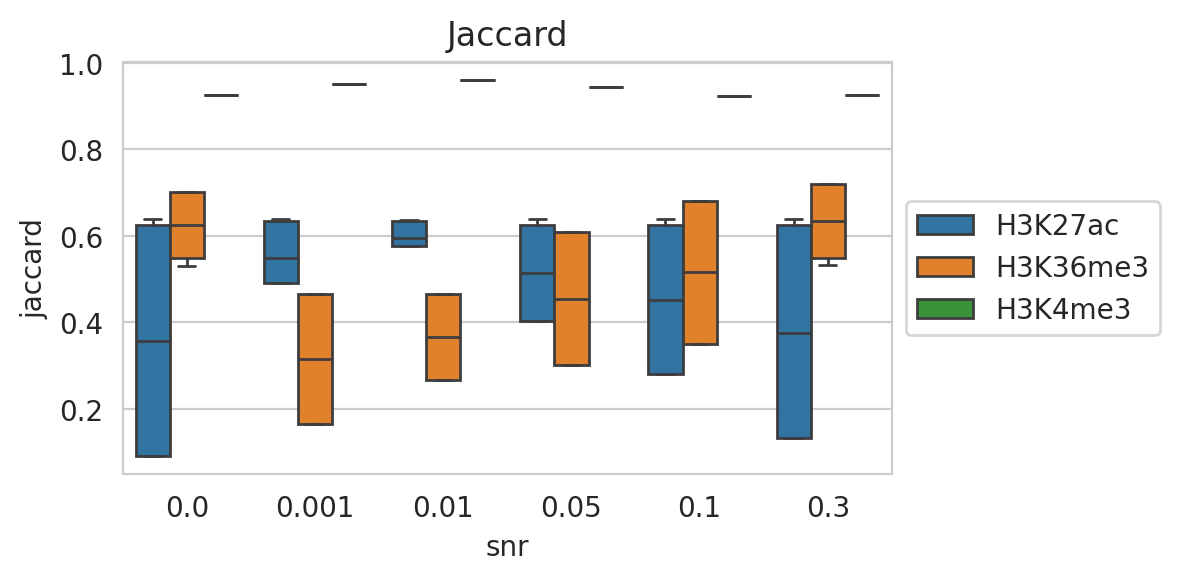

In [10]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=reps_overlap, x="snr", y='jaccard', hue='modification', ax=ax)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Jaccard')
plt.tight_layout()
plt.show()